# Introduction Statement

The Sure Tomorrow insurance company wants to solve several tasks with the help of Machine Learning and you are asked to evaluate that possibility.

- Task 1: Find customers who are similar to a given customer. This will help the company's agents with marketing.
- Task 2: Predict whether a new customer is likely to receive an insurance benefit. Can a prediction model do better than a dummy model?
- Task 3: Predict the number of insurance benefits a new customer is likely to receive using a linear regression model.
- Task 4: Protect clients' personal data without breaking the model from the previous task. It's necessary to develop a data transformation algorithm that would make it hard to recover personal information if the data fell into the wrong hands. This is called data masking, or data obfuscation. But the data should be protected in such a way that the quality of machine learning models doesn't suffer. You don't need to pick the best model, just prove that the algorithm works correctly.

# Data Preprocessing & Exploration

## Initialization

In [1]:
pip install scikit-learn --upgrade

     |████████████████████████████████| 30.8 MB 2.2 MB/s eta 0:00:01
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 0.24.1
    Uninstalling scikit-learn-0.24.1:
      Successfully uninstalled scikit-learn-0.24.1
Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
import pandas as pd

import seaborn as sns

import sklearn.linear_model
import sklearn.metrics
import sklearn.neighbors
import sklearn.preprocessing

from sklearn.model_selection import train_test_split

from IPython.display import display
import seaborn as sns
from sklearn.neighbors import NearestNeighbors
from sklearn.dummy import DummyClassifier
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import r2_score
import math
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier

## Load Data

In [3]:
df = pd.read_csv('/datasets/insurance_us.csv')

* We rename the colums to make the code look more consistent with its style.

In [4]:
df = df.rename(columns={'Gender': 'gender', 'Age': 'age', 'Salary': 'income', 'Family members': 'family_members', 'Insurance benefits': 'insurance_benefits'})

In [5]:
df.sample(10)

,gender,age,income,family_members,insurance_benefits
3979,1,30.0,36100.0,1,0
1860,1,36.0,52100.0,2,0
4129,1,19.0,35600.0,2,0
4758,0,30.0,58200.0,2,0
4831,0,34.0,25200.0,2,0
1007,1,19.0,57200.0,2,0
674,1,43.0,40800.0,1,1
1435,1,29.0,26200.0,0,0
3234,1,47.0,38200.0,2,1
540,1,29.0,38900.0,1,0


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   gender              5000 non-null   int64  
 1   age                 5000 non-null   float64
 2   income              5000 non-null   float64
 3   family_members      5000 non-null   int64  
 4   insurance_benefits  5000 non-null   int64  
dtypes: float64(2), int64(3)
memory usage: 195.4 KB


In [7]:
# we may want to fix the age type (from float to int) though this is not critical
df["age"] = df["age"].astype(int)


In [8]:
# check to see that the conversion was successful
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   gender              5000 non-null   int64  
 1   age                 5000 non-null   int64  
 2   income              5000 non-null   float64
 3   family_members      5000 non-null   int64  
 4   insurance_benefits  5000 non-null   int64  
dtypes: float64(1), int64(4)
memory usage: 195.4 KB


In [10]:
df["age"].value_counts()


19    223
25    214
31    212
26    211
22    209
27    209
32    206
28    204
29    203
30    202
23    202
21    200
20    195
36    193
33    191
24    182
35    179
34    177
37    147
39    141
38    139
41    129
18    117
40    114
42     93
43     77
44     74
45     73
46     60
47     47
49     37
50     27
48     26
52     22
51     21
53     11
55      9
54      7
56      5
59      3
60      2
57      2
58      2
65      1
61      1
62      1
Name: age, dtype: int64

In [11]:
df.describe()

,gender,age,income,family_members,insurance_benefits
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,0.499000,30.952800,39916.360000,1.194200,0.148000
std,0.500049,8.440807,9900.083569,1.091387,0.463183
min,0.000000,18.000000,5300.000000,0.000000,0.000000
25%,0.000000,24.000000,33300.000000,0.000000,0.000000
50%,0.000000,30.000000,40200.000000,1.000000,0.000000
75%,1.000000,37.000000,46600.000000,2.000000,0.000000
max,1.000000,65.000000,79000.000000,6.000000,5.000000


## EDA

* Let's quickly check whether there are certain groups of customers by looking at the pair plot.

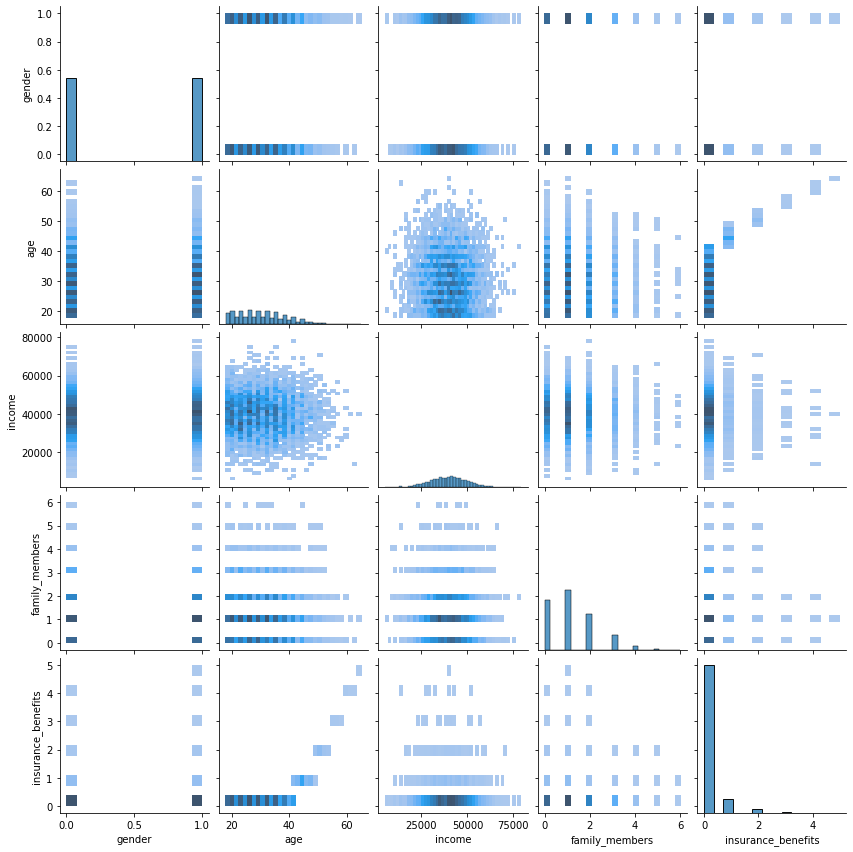

In [12]:
g = sns.pairplot(df, kind='hist')
g.fig.set_size_inches(12, 12)

# Task 1. Similar Customers

In [13]:
feature_names = ['gender', 'age', 'income', 'family_members']

In [14]:
def get_knn(df, n, k, metric):
    
    
    """
    Returns k nearest neighbors

    :param df: pandas DataFrame used to find similar objects within
    :param n: object no for which the nearest neighbours are looked for
    :param k: the number of the nearest neighbours to return
    :param metric: name of distance metric
    """

    nbrs = NearestNeighbors(n_neighbors=k, algorithm='brute', metric=metric)
    nbrs.fit(df[feature_names])
    nbrs_distances, nbrs_indices = nbrs.kneighbors([df.iloc[n][feature_names]], k, return_distance=True)
    df_res = pd.concat([
        df.iloc[nbrs_indices[0]], 
        pd.DataFrame(nbrs_distances.T, index=nbrs_indices[0], columns=['distance'])
        ], axis=1)
    
    return df_res

In [15]:
print(get_knn(df, 50, 5, 'manhattan'))

      gender  age   income  family_members  insurance_benefits  distance
50         1   28  39600.0               0                   0       0.0
3766       1   29  39600.0               0                   0       1.0
1547       0   21  39600.0               0                   0       8.0
270        1   36  39600.0               0                   0       8.0
3313       0   19  39600.0               0                   0      10.0


/opt/conda/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(


In [16]:
print(get_knn(df, 50, 5, 'euclidean'))

      gender  age   income  family_members  insurance_benefits  distance
50         1   28  39600.0               0                   0  0.000000
3766       1   29  39600.0               0                   0  1.000000
1547       0   21  39600.0               0                   0  7.071068
2930       0   21  39600.0               3                   0  7.681146
270        1   36  39600.0               0                   0  8.000000


/opt/conda/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(


* Scaling the data.

In [17]:
feature_names = ['gender', 'age', 'income', 'family_members']

transformer_mas = sklearn.preprocessing.MaxAbsScaler().fit(df[feature_names].to_numpy())

df_scaled = df.copy()
df_scaled.loc[:, feature_names] = transformer_mas.transform(df[feature_names].to_numpy())

In [18]:
df_scaled.sample(5)

,gender,age,income,family_members,insurance_benefits
1430,0.0,0.461538,0.568354,0.333333,0
85,0.0,0.384615,0.600000,0.333333,0
2513,0.0,0.476923,0.426582,0.500000,0
1196,0.0,0.369231,0.577215,0.000000,0
2382,0.0,0.323077,0.469620,0.166667,0


* Now, let's get similar records for a given one for every combination

In [19]:
print(get_knn(df_scaled, 50, 5, 'manhattan'))

      gender       age    income  family_members  insurance_benefits  distance
50       1.0  0.430769  0.501266             0.0                   0  0.000000
955      1.0  0.430769  0.502532             0.0                   0  0.001266
946      1.0  0.430769  0.500000             0.0                   0  0.001266
4898     1.0  0.430769  0.503797             0.0                   0  0.002532
116      1.0  0.430769  0.487342             0.0                   0  0.013924


/opt/conda/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(


In [20]:
print(get_knn(df_scaled, 50, 5, 'euclidean'))

      gender       age    income  family_members  insurance_benefits  distance
50       1.0  0.430769  0.501266             0.0                   0  0.000000
946      1.0  0.430769  0.500000             0.0                   0  0.001266
955      1.0  0.430769  0.502532             0.0                   0  0.001266
4898     1.0  0.430769  0.503797             0.0                   0  0.002532
116      1.0  0.430769  0.487342             0.0                   0  0.013924


/opt/conda/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(




Scaling the data affects the outcome kNN algorithim significantly. When we ran the unscaled features through the algorithm, it result in rather large distances as compared to the scaled data, in which all the distance outcomes resulted in much smaller values (between 0 and 1)



The Manhattan distance metric differs quite a bit when we compare the scaled data with the the unscaled data.

# Task 2. Is Customer Likely to Receive Insurance Benefit?

* In terms of machine learning we can look at this like a binary classification task.

With `insurance_benefits` being more than zero as the target, evaluate whether the kNN classification approach can do better than a dummy model.

Instructions:
- Build a KNN-based classifier and measure its quality with the F1 metric for k=1..10 for both the original data and the scaled one. That'd be interesting to see how k may influece the evaluation metric, and whether scaling the data makes any difference. You can use a ready implemention of the kNN classification algorithm from scikit-learn (check [the link](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html)) or use your own.
- Build the dummy model which is just random for this case. It should return "1" with some probability. Let's test the model with four probability values: 0, the probability of paying any insurance benefit, 0.5, 1.

The probability of paying any insurance benefit can be defined as

$$
P\{\text{insurance benefit received}\}=\frac{\text{number of clients received any insurance benefit}}{\text{total number of clients}}.
$$

Split the whole data in the 70:30 proportion for the training/testing parts.

In [21]:
# calculate the target

df['insurance_benefits_received'] = (df['insurance_benefits'] > 0).astype('int')
df['insurance_benefits_received']

0       0
1       1
2       0
3       0
4       0
       ..
4995    0
4996    0
4997    0
4998    0
4999    0
Name: insurance_benefits_received, Length: 5000, dtype: int64

In [22]:
# check for the class imbalance with value_counts()

df["insurance_benefits_received"].value_counts()

0    4436
1     564
Name: insurance_benefits_received, dtype: int64

* Class imbalance is quite significant, with there being over 7 times more people who recieved $0 in insurance benefits as compared to those who received an amount greater than 0. 
* Thus, accuracy metrics alone will not be appropriate to evaluate the model as it will result in a skewed outcome. However, because F1 metrics combine both recall and precision, we can use this to evaluate the model.

In [23]:
def eval_classifier(y_true, y_pred):
    
    f1_score = sklearn.metrics.f1_score(y_true, y_pred)
    print(f'F1: {f1_score:.2f}')
    
# if you have an issue with the following line, restart the kernel and run the notebook again
    cm = sklearn.metrics.confusion_matrix(y_true, y_pred, normalize='all')
    print('Confusion Matrix')
    print(cm)
# added plot for conf_matrix
    plt.figure(figsize=(9,9))
    sns.heatmap(cm, annot=True, fmt=".3f", linewidths=0.5, square = True, cmap = 'Blues_r');
    plt.ylabel('Actual label');
    plt.xlabel('Predicted label');
    all_sample_title = 'Confusion Matrix' 
    plt.title(all_sample_title, size = 15);
    plt.show()

In [24]:
# generating output of a random model

def rnd_model_predict(P, size, seed=42):

    rng = np.random.default_rng(seed=seed)
    return rng.binomial(n=1, p=P, size=size)

The probability: 0.00
F1: 0.00
Confusion Matrix
[[0.8872 0.    ]
 [0.1128 0.    ]]


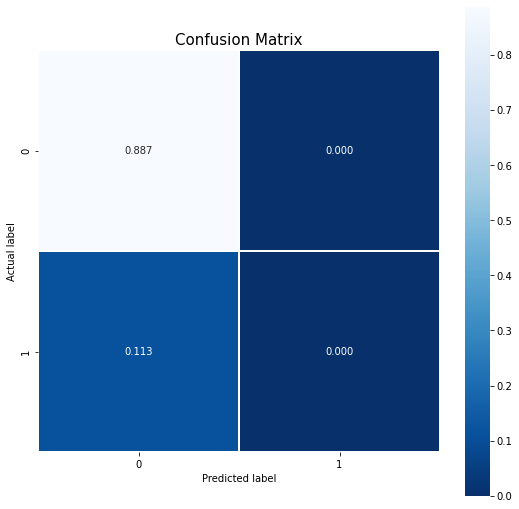


The probability: 0.11
F1: 0.12
Confusion Matrix
[[0.7914 0.0958]
 [0.0994 0.0134]]


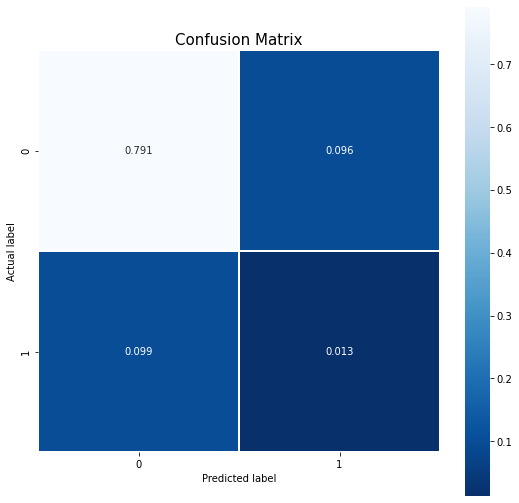


The probability: 0.50
F1: 0.20
Confusion Matrix
[[0.456  0.4312]
 [0.053  0.0598]]


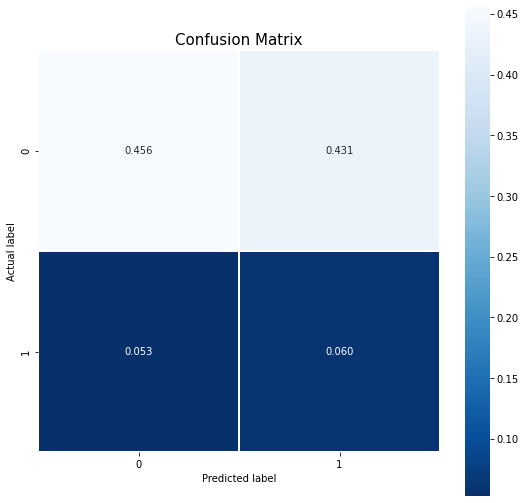


The probability: 1.00
F1: 0.20
Confusion Matrix
[[0.     0.8872]
 [0.     0.1128]]


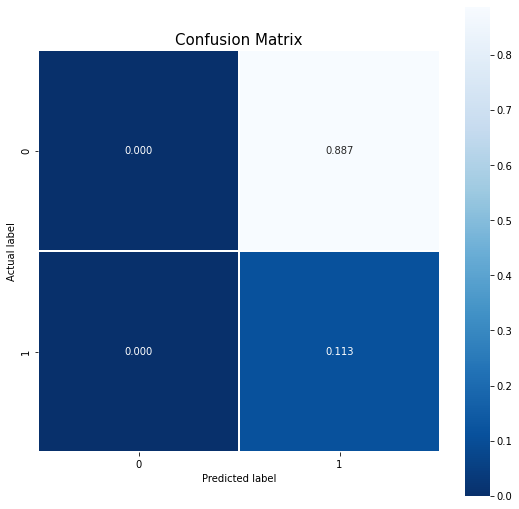

In [25]:
for P in [0, df['insurance_benefits_received'].sum() / len(df), 0.5, 1]:

    print(f'The probability: {P:.2f}')
    y_pred_rnd = rnd_model_predict(P, size = len(df), seed=42)
        
    eval_classifier(df['insurance_benefits_received'], y_pred_rnd)
    
    print()

* The F1 scores for the dummy models are rather low. The highest F1 score is 0.20.

In [26]:
features = df.drop(['insurance_benefits_received', 'insurance_benefits'], axis=1)
target = df['insurance_benefits_received']
features_train, features_test, target_train, target_test = train_test_split(features, target, test_size = 0.3, random_state=0)
print('Training:', features_train.shape, target_train.shape)
print('Testing:', features_test.shape, target_test.shape)

Training: (3500, 4) (3500,)
Testing: (1500, 4) (1500,)


In [27]:
print('\nUnscaled data used for kNN')
unscaled_f1 = []
for k in range(1,20):
    knc = sklearn.neighbors.KNeighborsClassifier(n_neighbors=k)
    knc.fit(features_train, target_train)
    knc_pred = knc.predict(features_test)
    f1_score = sklearn.metrics.f1_score(target_test, knc_pred)
    unscaled_f1.append(f1_score)
    print(f'N_neighbors: {k}, F1: {f1_score:.2f}')


Unscaled data used for kNN
N_neighbors: 1, F1: 0.61
N_neighbors: 2, F1: 0.44
N_neighbors: 3, F1: 0.44
N_neighbors: 4, F1: 0.20
N_neighbors: 5, F1: 0.20
N_neighbors: 6, F1: 0.09
N_neighbors: 7, F1: 0.16
N_neighbors: 8, F1: 0.10
N_neighbors: 9, F1: 0.11
N_neighbors: 10, F1: 0.00
N_neighbors: 11, F1: 0.00
N_neighbors: 12, F1: 0.00
N_neighbors: 13, F1: 0.01
N_neighbors: 14, F1: 0.00
N_neighbors: 15, F1: 0.00
N_neighbors: 16, F1: 0.00
N_neighbors: 17, F1: 0.01
N_neighbors: 18, F1: 0.01
N_neighbors: 19, F1: 0.01


In [28]:
#Scale features
scaler = sklearn.preprocessing.MaxAbsScaler()
scaler.fit(features_train) # fit to training data
features_train_scaled = scaler.transform(features_train)
features_test_scaled = scaler.transform(features_test)

In [29]:
#K-NeighborsClassifier for k in range 10 + f1_score. Scaled data
print('\nScaled data used for kNN')
scaled_f1 = []
for k in range(1,20):
    knc = sklearn.neighbors.KNeighborsClassifier(n_neighbors=k)
    knc.fit(features_train_scaled, target_train)
    knc_pred = knc.predict(features_test_scaled)
    f1_score = sklearn.metrics.f1_score(target_test, knc_pred)
    scaled_f1.append(f1_score)
    print(f'N_neighbors: {k}, F1: {f1_score:.2f}')



Scaled data used for kNN
N_neighbors: 1, F1: 0.95
N_neighbors: 2, F1: 0.92
N_neighbors: 3, F1: 0.94
N_neighbors: 4, F1: 0.89
N_neighbors: 5, F1: 0.91
N_neighbors: 6, F1: 0.89
N_neighbors: 7, F1: 0.91
N_neighbors: 8, F1: 0.89
N_neighbors: 9, F1: 0.91
N_neighbors: 10, F1: 0.90
N_neighbors: 11, F1: 0.91
N_neighbors: 12, F1: 0.89
N_neighbors: 13, F1: 0.90
N_neighbors: 14, F1: 0.89
N_neighbors: 15, F1: 0.90
N_neighbors: 16, F1: 0.89
N_neighbors: 17, F1: 0.90
N_neighbors: 18, F1: 0.89
N_neighbors: 19, F1: 0.90


In [30]:
knn = KNeighborsClassifier(n_neighbors = 5)
knn.fit(features_train, target_train)

KNeighborsClassifier()

F1: 0.20
Confusion Matrix
[[0.888      0.00933333]
 [0.09       0.01266667]]


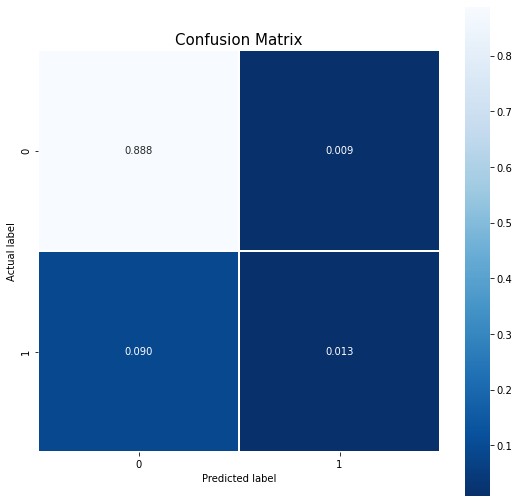

In [31]:
eval_classifier(target_test, knn.predict(features_test))

* The  model using unscaled data generates an F1 score of 0.20, which is pretty low.

# Task 3. Regression (with Linear Regression)

With `insurance_benefits` as the target, evaluate what RMSE would be for a Linear Regression model.

Build your own implementation of LR. For that, recall how the linear regression task's solution is formulated in terms of LA. Check RMSE for both the original data and the scaled one. Can you see any difference in RMSE between these two cases?

Let's denote
- $X$ — feature matrix, each row is a case, each column is a feature, the first column consists of unities
- $y$ — target (a vector)
- $\hat{y}$ — estimated tagret (a vector)
- $w$ — weight vector

The task of linear regression in the language of matrices can be formulated as

$$
y = Xw
$$

The training objective then is to find such $w$ that it would minimize the L2-distance (MSE) between $Xw$ and $y$:

$$
\min_w d_2(Xw, y) \quad \text{or} \quad \min_w \text{MSE}(Xw, y)
$$

It appears that there is analytical solution for the above:

$$
w = (X^T X)^{-1} X^T y
$$

The formula above can be used to find the weights $w$ and the latter can be used to calculate predicted values

$$
\hat{y} = X_{val}w
$$

Split the whole data in the 70:30 proportion for the training/validation parts. Use the RMSE metric for the model evaluation.

In [32]:
class MyLinearRegression:
    
    def __init__(self):
        
        self.weights = None
    
    def fit(self, X, y):
        
        # adding the unities
        X2 = np.append(np.ones([len(X), 1]), X, axis=1)
        self.weights = np.linalg.inv(X2.T @ X2) @ X2.T @ y

    def predict(self, X):
        
        # adding the unities
        X2 = np.append(np.ones([len(X), 1]), X, axis=1)
        y_pred = X2.dot(self.weights)
        
        return y_pred

In [33]:
def eval_regressor(y_true, y_pred):
    
    rmse = math.sqrt(sklearn.metrics.mean_squared_error(y_true, y_pred))
    print(f'RMSE: {rmse:.2f}')
    
    r2_score = math.sqrt(sklearn.metrics.r2_score(y_true, y_pred))
    print(f'R2: {r2_score:.2f}')    

In [34]:
#LR for Scaled data
X = df[['age', 'gender', 'income', 'family_members']].to_numpy()
y = df['insurance_benefits'].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=12345)

lr = MyLinearRegression()

lr.fit(X_train, y_train)
print(lr.weights)

y_test_pred = lr.predict(X_test)
eval_regressor(y_test, y_test_pred)

[-9.43539012e-01  3.57495491e-02  1.64272726e-02 -2.60743659e-07
 -1.16902127e-02]
RMSE: 0.34
R2: 0.66


In [35]:
print('Results with scaled data\n')

X = df_scaled[['age', 'gender', 'income', 'family_members']].to_numpy()
y = df_scaled['insurance_benefits'].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify = df['insurance_benefits_received'], random_state=12345)

lr = MyLinearRegression()

lr.fit(X_train, y_train)
print('Linear Regression weights:\n', lr.weights)

y_test_pred = lr.predict(X_test)
eval_regressor(y_test, y_test_pred)

Results with scaled data

Linear Regression weights:
 [-9.65464676e-01  2.36997150e+00  6.34628613e-03  7.22175049e-04
 -7.83293864e-02]
RMSE: 0.34
R2: 0.65


* As we can see in the above results, both the scaled data and uncaled data produce the same outcome in this LR model. The RMSE percentage ends up being 34%, which demonstrates a higher percentage of error produced by the model. The R2 percentage of 66% indicates a medium-poor fit on a 0-100 scale.

<div class="alert alert-success">
<b>Reviewer's comment</b>

Yep! Note that scaling can be useful for linear regression in different circumstances, for example if we apply L1/L2 regularization or train the model using stochastic gradient descent

</div>

# Task 4. Obfuscating Data

It best to obfuscate data by multiplying the numerical features (remember, they can be seen as the matrix $X$) by an invertible matrix $P$. 

$$
X' = X \times P
$$

Try to do that and check how the features' values will look like after the transformation. By the way, the intertible property is important here so make sure that $P$ is indeed invertible.

You may want to review the 'Matrices and Matrix Operations -> Matrix Multiplication' lesson to recall the rule of matrix multiplication and its implementation with NumPy.

In [36]:
personal_info_column_list = ['gender', 'age', 'income', 'family_members']
df_pn = df[personal_info_column_list]

In [37]:
X = df_pn.to_numpy()
X

array([[1.00e+00, 4.10e+01, 4.96e+04, 1.00e+00],
       [0.00e+00, 4.60e+01, 3.80e+04, 1.00e+00],
       [0.00e+00, 2.90e+01, 2.10e+04, 0.00e+00],
       ...,
       [0.00e+00, 2.00e+01, 3.39e+04, 2.00e+00],
       [1.00e+00, 2.20e+01, 3.27e+04, 3.00e+00],
       [1.00e+00, 2.80e+01, 4.06e+04, 1.00e+00]])

Generating a random matrix $P$.

In [38]:
rng = np.random.default_rng(seed=42)
P = rng.random(size=(X.shape[1], X.shape[1]))

Checking the matrix $P$ is invertible

In [39]:
P_inv=np.linalg.inv(P)

In [40]:
np.linalg.det(P)

0.24339135998015463

* P is invertible 

In [41]:
X_not=X.dot(P)
X_rev=X_not.dot(P_inv)

In [42]:
#obfuscated data
X_not

array([[ 6359.71527314, 22380.40467609, 18424.09074184, 46000.69669016],
       [ 4873.29406479, 17160.36702982, 14125.78076133, 35253.45577301],
       [ 2693.11742928,  9486.397744  ,  7808.83156024, 19484.86063067],
       ...,
       [ 4346.2234249 , 15289.24126492, 12586.16264392, 31433.50888552],
       [ 4194.09324155, 14751.9910242 , 12144.02930637, 30323.88763426],
       [ 5205.46827354, 18314.24814446, 15077.01370762, 37649.59295455]])

* Yes, we would be able to use the data above (X_not) to guess ages/incomes of the customers.

Can you recover the original data from $X'$ if you know $P$? Try to check that with calculations by moving $P$ from the right side of the formula above to the left one. The rules of matrix multiplcation are really helpful here.

In [43]:
X_not=X.dot(P)
X_rev=X_not.dot(P_inv)
X_rev

array([[ 1.00000000e+00,  4.10000000e+01,  4.96000000e+04,
         1.00000000e+00],
       [ 1.67952800e-12,  4.60000000e+01,  3.80000000e+04,
         1.00000000e+00],
       [-6.23021448e-13,  2.90000000e+01,  2.10000000e+04,
        -2.03032656e-13],
       ...,
       [ 1.57996161e-12,  2.00000000e+01,  3.39000000e+04,
         2.00000000e+00],
       [ 1.00000000e+00,  2.20000000e+01,  3.27000000e+04,
         3.00000000e+00],
       [ 1.00000000e+00,  2.80000000e+01,  4.06000000e+04,
         1.00000000e+00]])

Print all three cases for a few customers
- The original data
- The transformed one
- The reversed (recovered) one

In [44]:
print(pd.DataFrame(X))
print(pd.DataFrame(X_not))
print(pd.DataFrame(X_rev))

        0     1        2    3
0     1.0  41.0  49600.0  1.0
1     0.0  46.0  38000.0  1.0
2     0.0  29.0  21000.0  0.0
3     0.0  21.0  41700.0  2.0
4     1.0  28.0  26100.0  0.0
...   ...   ...      ...  ...
4995  0.0  28.0  35700.0  2.0
4996  0.0  34.0  52400.0  1.0
4997  0.0  20.0  33900.0  2.0
4998  1.0  22.0  32700.0  3.0
4999  1.0  28.0  40600.0  1.0

[5000 rows x 4 columns]
                0             1             2             3
0     6359.715273  22380.404676  18424.090742  46000.696690
1     4873.294065  17160.367030  14125.780761  35253.455773
2     2693.117429   9486.397744   7808.831560  19484.860631
3     5345.603937  18803.227203  15479.148373  38663.061863
4     3347.176735  11782.829283   9699.998942  24211.273378
...           ...           ...           ...           ...
4995  4577.581382  16107.740932  13259.688205  33107.974380
4996  6717.000247  23634.217067  19456.138634  48589.438841
4997  4346.223425  15289.241265  12586.162644  31433.508886
4998  4194.0932

*Marginal differences can be observed between the original data and the reverted data most likely due to mathematical float rounding using .dot() function.

## Proof That Data Obfuscation Can Work with LR

The regression task has been solved with linear regression in this project. Your next task is to prove _analytically_ that the given obfuscation method won't affect linear regression in terms of predicted values i.e. their values will remain the same. Can you believe that? Well, you don't have to, you should prove it!

So, the data is obfuscated and there is $X \times P$ instead of just $X$ now. Consequently, there are other weights $w_P$ as
$$
w = (X^T X)^{-1} X^T y \quad \Rightarrow \quad w_P = [(XP)^T XP]^{-1} (XP)^T y
$$

How would $w$ and $w_P$ be linked if you simplify the formula for $w_P$ above? 

What would be predicted values with $w_P$? 

What does that mean for the quality of linear regression if you measure it with RMSE?

Check Appendix B Properties of Matrices in the end of the notebook. There are useful formulas in there!

No code is necessary in this section, only analytical explanation!

(1)The inverse of matrix P links 𝑤 and 𝑤𝑃 as we see in the formula 𝑤𝑃= [P]-1𝑤. 
(2)The predicted values with 𝑤𝑃 will be P-1 multiplied by w. (wp=P-1w)
(3)The RMSE measure should be the same with the obfuscated data as it would with the original data.


**Analytical proof**

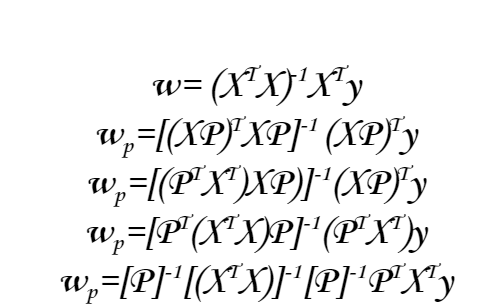

After this, we note tht the order must now be reversed when applying inversion:

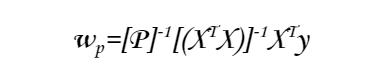

Since we know that:

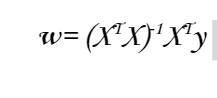

We end up with:

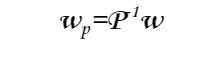

## Test Linear Regression With Data Obfuscation

Now, let's prove Linear Regression can work computationally with the chosen obfuscation transformation.

Build a procedure or a class that runs Linear Regression optionally with the obfuscation. You can use either a ready implementation of Linear Regression from sciki-learn or your own.

Run Linear Regression for the original data and the obfuscated one, compare the predicted values and the RMSE, $R^2$ metric values. Is there any difference?

**Procedure**

- Create a square matrix $P$ of random numbers.
- Check that it is invertible. If not, repeat the first point until we get an invertible matrix.
- <! your comment here !>
- Use $XP$ as the new feature matrix

In [45]:
class MyLinearRegression2:
    
    def __init__(self, data):
        self.weights = None
        self.data = data
        
    def fit(self, X, y):
        # adding the unities
        X2 = np.append(np.ones([len(X), 1]), X, axis=1)
        weights = np.linalg.inv(X2.T.dot(X2)).dot(X2.T).dot(y)
        self.weights = weights[1:]
        self.bias = weights[0]

    def predict(self, X):
        # adding the unities
        X2 = np.append(np.ones([len(X), 1]), X, axis=1)
        y_pred = X.dot(self.weights) + self.bias
        return y_pred

In [46]:
X = X
y = df['insurance_benefits'].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=12345)

lr = MyLinearRegression2(X)

lr.fit(X_train, y_train)
print(lr.weights)

y_test_pred = lr.predict(X_test)
eval_regressor(y_test, y_test_pred)

[ 1.64272726e-02  3.57495491e-02 -2.60743659e-07 -1.16902127e-02]
RMSE: 0.34
R2: 0.66


In [47]:
X = X_not
y = df['insurance_benefits'].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=12345)

lr = MyLinearRegression2(X_not)

lr.fit(X_train, y_train)
print(lr.weights)

y_test_pred = lr.predict(X_test)
eval_regressor(y_test, y_test_pred)

[-0.05791721 -0.01546571  0.09871894 -0.02397536]
RMSE: 0.34
R2: 0.66


* There is no difference in the quality of the models before transformation as compared to after transformation. The RMSE and R2 values are identical.

# Conclusions

* The data was loaded and inspected. Upon inspection, we found a rather large class imbalance of around 1:7, with there being a much larger class for people who did no recieve inusrance benefits. It was apparent that scaling the data significantly impacted the results for both Euclidean and Manhattan distance metrics.  

* Regarding the KNN classification, we noted that scaling the data also impacted the resulting f1 scores on the random models, with the best F1 score being 0.95 (KNN=1) compared to the unscaled data which resulted in an F1 score of 0.20 (KNN=5)

* Finally, the data was obfuscated and invertibility was confirmed. It was concluded via analytical proofs Linear regression runs of both the original and obfuscated data that obfuscating the data does not change the predictive outcomes of the model. 

# Appendices 

## Appendix A: Writing Formulas in Jupyter Notebooks

You can write formulas in your Jupyter Notebook in a markup language provided by a high-quality publishing system called $\LaTeX$ (pronounced "Lah-tech"), and they will look like formulas in textbooks.

To put a formula in a text, put the dollar sign (\\$) before and after the formula's text e.g. $\frac{1}{2} \times \frac{3}{2} = \frac{3}{4}$ or $y = x^2, x \ge 1$.

If a formula should be in its own paragraph, put the double dollar sign (\\$\\$) before and after the formula text e.g.

$$
\bar{x} = \frac{1}{n}\sum_{i=1}^{n} x_i.
$$

The markup language of [LaTeX](https://en.wikipedia.org/wiki/LaTeX) is very popular among people who use formulas in their articles, books and texts. It can be complex but its basics are easy. Check this two page [cheatsheet](http://tug.ctan.org/info/undergradmath/undergradmath.pdf) for learning how to compose the most common formulas.

## Appendix B: Properties of Matrices

Matrices have many properties in Linear Algebra. A few of them are listed here which can help with the analytical proof in this project.

<table>
<tr>
<td>Distributivity</td><td>$A(B+C)=AB+AC$</td>
</tr>
<tr>
<td>Non-commutativity</td><td>$AB \neq BA$</td>
</tr>
<tr>
<td>Associative property of multiplication</td><td>$(AB)C = A(BC)$</td>
</tr>
<tr>
<td>Multiplicative identity property</td><td>$IA = AI = A$</td>
</tr>
<tr>
<td></td><td>$A^{-1}A = AA^{-1} = I$
</td>
</tr>    
<tr>
<td></td><td>$(AB)^{-1} = B^{-1}A^{-1}$</td>
</tr>    
<tr>
<td>Reversivity of the transpose of a product of matrices,</td><td>$(AB)^T = B^TA^T$</td>
</tr>    
</table>